In [ ]:
# connect to google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Data loader and preprocessing

In [ ]:
# Applying Transforms to the Data
# Data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test_balanced': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Set the directory for the data
data_dir = '/content/drive/MyDrive/projet ML DL/dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid','test','test_balanced']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid','test','test_balanced']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test','test_balanced']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#dataset_sizes['train']
#dataset_sizes['valid']
#dataset_sizes['test']
#dataset_sizes['test_balanced']

8852

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
class_names = image_datasets['train'].classes
class_names

['damage', 'no_damage']

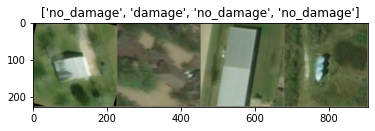

In [ ]:
# visualize a few training images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs -1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test_model(model,datas,device):
    CM=0
    model.eval()
    for inputs, labels in datas:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        outputs = model(inputs) #file_name
        preds = torch.argmax(outputs.data, 1)
        CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1])

    tn=CM[0][0]
    tp=CM[1][1]
    fp=CM[0][1]
    fn=CM[1][0]
    acc=np.sum(np.diag(CM)/np.sum(CM))
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
    f1 = ((2*sensitivity*precision)/(sensitivity+precision))*100

    print('Accuracy : %f %%' % (100 * acc))
    print('F1 : ',f1)
                
    return acc, f1

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Transfer learning Pytorch - Approach A : feature extraction

In [ ]:
# Load pretrained ResNet50 Model :
model50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#freeze the convolutional base created from the previous step and use it as a feature extractor
for param in model50.parameters():
    param.requires_grad = False

In [ ]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = models.resnet50(pretrained=True).fc.in_features
model50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2), 
    nn.LogSoftmax(dim=1) 
)

In [ ]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()

# feature extraction:
params_to_update = []
for name,param in model50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.Adam(params_to_update, lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# Convert model to be used on GPU
model50 = model50.to(device)

In [ ]:
model_conv = train_model(model50, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.4691 Acc: 0.7705
valid Loss: 0.2670 Acc: 0.9080

Epoch 1/29
----------
train Loss: 0.4042 Acc: 0.8151
valid Loss: 0.2712 Acc: 0.9090

Epoch 2/29
----------
train Loss: 0.3886 Acc: 0.8232
valid Loss: 0.2430 Acc: 0.9120

Epoch 3/29
----------
train Loss: 0.3641 Acc: 0.8322
valid Loss: 0.2143 Acc: 0.9175

Epoch 4/29
----------
train Loss: 0.3583 Acc: 0.8354
valid Loss: 0.2239 Acc: 0.9130

Epoch 5/29
----------
train Loss: 0.3505 Acc: 0.8448
valid Loss: 0.1940 Acc: 0.9265

Epoch 6/29
----------
train Loss: 0.3489 Acc: 0.8441
valid Loss: 0.1922 Acc: 0.9285

Epoch 7/29
----------
train Loss: 0.3181 Acc: 0.8557
valid Loss: 0.2079 Acc: 0.9225

Epoch 8/29
----------
train Loss: 0.3279 Acc: 0.8494
valid Loss: 0.1836 Acc: 0.9330

Epoch 9/29
----------
train Loss: 0.3197 Acc: 0.8545
valid Loss: 0.1790 Acc: 0.9315

Epoch 10/29
----------
train Loss: 0.3228 Acc: 0.8588
valid Loss: 0.1809 Acc: 0.9345

Epoch 11/29
----------
train Loss: 0.3187 Acc: 0.8630
valid Loss

Best model : Acc: 0.939, temps = 43m39s avec cuda


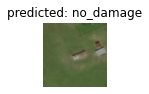

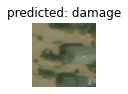

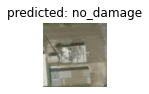

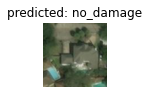

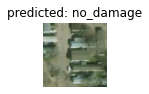

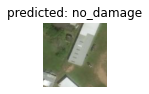

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
#save trained model
torch.save(model_conv, '/content/drive/MyDrive/projet ML DL/models/model50_feature.pth')

In [ ]:
# prediction on unbalanced test set 
test_model(model_conv,dataloaders["test"],device)

Accuracy : 94.622684 %
F1 :  76.66666666666666


(0.9462268413917758, 76.66666666666666)

Sur le test non équilibré, acc = 0.946 %, f1 = 0.7667, 
temps= 8mn avec cuda

In [ ]:
# prediction on balanced test set
test_model(model_conv,dataloaders["test_balanced"],device)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy : 93.450000 %
F1 :  93.32654100866023


(0.9345, 93.32654100866023)

Sur le test équilibré, acc = 93.45 %, f1 = 0.93265, temps = 1m45s avec cuda

# Transfer learning Pytorch - Approach B : fine-tuning

In [ ]:
# Load pretrained ResNet50 Model :
model50B = models.resnet50(pretrained=True)  

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputsB = model50B.fc.in_features
model50B.fc = nn.Sequential(
    nn.Linear(fc_inputsB, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2), 
    nn.LogSoftmax(dim=1) 
)

In [ ]:
# Convert model to be used on GPU
model50B = model50B.to(device)

In [ ]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer_convB = optim.Adam(model50B.fc.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_schedulerB = lr_scheduler.StepLR(optimizer_convB, step_size=7, gamma=0.1)

In [ ]:
model50B = train_model(model50B, criterion, optimizer_convB,
                         exp_lr_schedulerB, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4663 Acc: 0.7797
valid Loss: 0.2845 Acc: 0.8995

Epoch 1/49
----------
train Loss: 0.3957 Acc: 0.8225
valid Loss: 0.3419 Acc: 0.8635

Epoch 2/49
----------
train Loss: 0.3681 Acc: 0.8335
valid Loss: 0.2148 Acc: 0.9205

Epoch 3/49
----------
train Loss: 0.3670 Acc: 0.8321
valid Loss: 0.2059 Acc: 0.9245

Epoch 4/49
----------
train Loss: 0.3615 Acc: 0.8336
valid Loss: 0.2095 Acc: 0.9245

Epoch 5/49
----------
train Loss: 0.3471 Acc: 0.8474
valid Loss: 0.2759 Acc: 0.8865

Epoch 6/49
----------
train Loss: 0.3524 Acc: 0.8402
valid Loss: 0.1765 Acc: 0.9295

Epoch 7/49
----------
train Loss: 0.3211 Acc: 0.8561
valid Loss: 0.1965 Acc: 0.9295

Epoch 8/49
----------
train Loss: 0.3237 Acc: 0.8605
valid Loss: 0.1916 Acc: 0.9335

Epoch 9/49
----------
train Loss: 0.3205 Acc: 0.8565
valid Loss: 0.2145 Acc: 0.9270

Epoch 10/49
----------
train Loss: 0.3097 Acc: 0.8601
valid Loss: 0.1941 Acc: 0.9255

Epoch 11/49
----------
train Loss: 0.3122 Acc: 0.8591
valid Loss

Best model : Acc: 0.9405, temps = 2h23m sans cuda

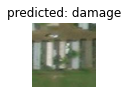

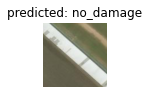

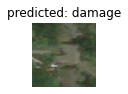

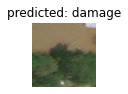

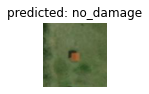

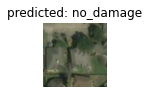

In [ ]:
visualize_model(model50B)

plt.ioff()
plt.show()

In [ ]:
#save trained model
torch.save(model50B, '/content/drive/MyDrive/projet ML DL/models/model50_finetuning.pth')

In [ ]:
# prediction on unbalanced test set:
test_model(model50B,dataloaders["test"],device)

Accuracy : 94.713059 %
F1 :  76.99115044247787


(0.94713059195662, 76.99115044247787)

Sur le test non équilibré, acc = 94.713059 %, f1 = 0.7699115044247787, temps= 22mn

In [ ]:
# prediction on balanced test set:
test_model(model50B,dataloaders["test_balanced"],device)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy : 93.700000 %
F1 :  93.56486210418795


(0.937, 93.56486210418795)

Sur le test équilibré, acc = 93.7 %, f1 = 0.9356486210418795, temps= 4mn

In [ ]:
modelvgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

# Transfer learning sklearn - Approach A : feature extraction

In [ ]:
conv_base = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
batch_size = 32

def extract_features(data, sample_count):
    features = np.zeros(shape=(sample_count))
    labels = np.zeros(shape = (sample_count))
    conv_base.eval()
    i = 0
    for inputs_batch, labels_batch in data:
      with torch.no_grad():
        outputs = conv_base(inputs_batch) #file_name
        features_batch = torch.argmax(outputs.data, 1)
    
      features[i * batch_size: (i + 1) * batch_size] = features_batch
      labels[i * batch_size: (i + 1) * batch_size] = labels_batch
      i += 1
      if i * batch_size >= sample_count: #generators yield data indefinitely
          break                          #have to break after we have seen every image once
    return features, labels

In [ ]:
train_features, train_labels = extract_features(dataloaders['train'],dataset_sizes['train'])
validation_features, validation_labels = extract_features(dataloaders['valid'], dataset_sizes['valid'])
test_features, test_labels = extract_features(dataloaders['test'], dataset_sizes['test'])

ValueError: ignored

In [ ]:
#the extracted features are of shape (sample_count, 4, 4, 512), we must flatten them to (sample_count, 8192)
train_features = train_features.reshape(-1,1)
validation_features = validation_features.reshape(-1,1)
test_features = test_features.reshape(-1,1)

In [ ]:
parameters = {'max_depth' : np.arange(start = 2, stop = 10, step = 1) , 
              'min_samples_leaf' : np.arange(start = 2, stop = 4, step = 1),
              'min_samples_split' : np.arange(start = 2, stop = 5, step = 1),
              'learning_rate':[0.01,0.1,1,1.5]}


In [ ]:
modele_boost = GradientBoostingClassifier(random_state=0)

In [ ]:
f1 = make_scorer(f1_score , average='macro')

modele_boost = GridSearchCV(modele_boost,
                                  parameters,
                                  scoring = f1,
                                  verbose = 2, 
                                  cv = 5)

modele_boost.fit(train_features,train_labels)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=2; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=2, min_samples_leaf=2, min_samples_split=3; total time=   0.2s
[CV] END learning_r

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.01, 0.1, 1, 1.5],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([2, 3]),
                         'min_samples_split': array([2, 3, 4])},
             scoring=make_scorer(f1_score, average=macro), verbose=2)

In [ ]:
print("Voici les paramètres du meilleure modèle : " + 
      str(modele_boost.best_estimator_))
print("Voici le "  + str(modele_boost.scorer_) + 
      " du meilleure modèle : " + str(modele_boost.best_score_))

Voici les paramètres du meilleure modèle : GradientBoostingClassifier(learning_rate=1, max_depth=5, min_samples_leaf=3,
                           random_state=0)
Voici le make_scorer(f1_score, average=macro) du meilleure modèle : 0.7293326577448659


In [ ]:
#unbalanced test set 
score1 = modele_boost.score(test_features, test_labels)
print("Test acc = ", score1)

Test acc =  0.5065132333936603


In [ ]:
#balanced test set
score2 = modele_boost.score(validation_features, validation_labels)
print("Validation acc = ", score2)

Validation acc =  0.7057742942088783


# Our CNN model

In [ ]:
# Define our Convolutional Neural Network

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size=3), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4608, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2), 
            nn.LogSoftmax(dim=1)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


net = MyModel().to(device)

In [ ]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#Train the network
net = train_model(net, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5116 Acc: 0.7265
valid Loss: 0.3070 Acc: 0.8665

Epoch 1/29
----------
train Loss: 0.2835 Acc: 0.8839
valid Loss: 0.1961 Acc: 0.9185

Epoch 2/29
----------
train Loss: 0.2164 Acc: 0.9128
valid Loss: 0.3120 Acc: 0.8615

Epoch 3/29
----------
train Loss: 0.1878 Acc: 0.9287
valid Loss: 0.1849 Acc: 0.9255

Epoch 4/29
----------
train Loss: 0.1752 Acc: 0.9347
valid Loss: 0.1480 Acc: 0.9395

Epoch 5/29
----------
train Loss: 0.1637 Acc: 0.9382
valid Loss: 0.2004 Acc: 0.9290

Epoch 6/29
----------
train Loss: 0.1493 Acc: 0.9417
valid Loss: 0.1461 Acc: 0.9450

Epoch 7/29
----------
train Loss: 0.1226 Acc: 0.9529
valid Loss: 0.1112 Acc: 0.9615

Epoch 8/29
----------
train Loss: 0.1125 Acc: 0.9568
valid Loss: 0.1083 Acc: 0.9625

Epoch 9/29
----------
train Loss: 0.1118 Acc: 0.9604
valid Loss: 0.1058 Acc: 0.9620

Epoch 10/29
----------
train Loss: 0.1091 Acc: 0.9579
valid Loss: 0.1052 Acc: 0.9620

Epoch 11/29
----------
train Loss: 0.1087 Acc: 0.9579
valid Loss

Best model : validation Acc: 0.9725, temps = 30m28s avec cuda

In [ ]:
#save trained model
torch.save(net, '/content/drive/MyDrive/projet ML DL/models/ourCNN.pth')

In [ ]:
# load model
net = torch.load('/content/drive/MyDrive/projet ML DL/models/ourCNN.pth', map_location=device)
net.eval()

MyModel(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (20): Conv2d

In [ ]:
#Test the network on the unbalanced test set 
test_model(net,dataloaders["test"],device)

Accuracy : 96.915951 %
F1 :  85.92057761732853


(0.969159511974695, 85.92057761732853)

Sur le test non équilibré, acc = 96.915951 %, f1 = 0.8592057761732853, temps= 15mn sans cuda

In [ ]:
#Test the network on the balanced test set 
test_model(net,dataloaders["test_balanced"],device)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy : 97.150000 %
F1 :  97.1796140524493


(0.9715, 97.1796140524493)

Sur le test équilibré, acc = 97.15 %, f1 = 0.971796140524493 , temps= 3 mn sans cuda